# Predicting Potential Strokes

Group Members: Maxwell Arena, Nathan Poteet, Sanjay Srikumar, Akshay Shivkumar

# Why is it important to predict strokes?
Strokes are the 4th health related cause of death in the United States, trailing behind Heart Disease, Cancer, and Lower Respiratory Ilnesses. In 2019 alone, there were 150,005 deaths related to strokes. There is a lot of overlap between heart disease and strokes according to the CDC, and as they are all cardiovasular illnesses, which combined, account for 1/3 of all deaths in the United States. There are a number of ways that strokes affect the daily lives of people in this country, such as loss of major sensory function and reduced brain capacity. We see that dogs are fit to predict cancer in potential cancer patients given a blood sample to almost a 97% accuracy. 

Sources taken from statistics from the Center for Disease Control (cdc.gov)







In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import requests
from sklearn import svm, tree
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras


In [17]:
df = pd.read_csv('./healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [18]:
df = df.dropna() # Getting rid of rows with NaN 

# Mapping categorical variables to numbers so the model can make sense of data
dict1 = {'Self-employed': 0, 'Private': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4}
dict2 = {'Male': 0, 'Female': 1, 'Other': 2}
dict3 = {'never smoked': 0, 'formerly smoked': 1, 'Unknown': 2, 'smokes': 3}
dict4 = {'Urban': 0, 'Rural': 1}
dict5 = {'No': 0, 'Yes': 1}
for row in df.iterrows():
  df.at[row[0], 'work_type'] = dict1[row[1]['work_type']]
  df.at[row[0], 'gender'] = dict2[row[1]['gender']]
  df.at[row[0], 'smoking_status'] = dict3[row[1]['smoking_status']]
  df.at[row[0], 'Residence_type'] = dict4[row[1]['Residence_type']]
  df.at[row[0], 'ever_married'] = dict5[row[1]['ever_married']]
  
tmp = df.drop(['stroke', 'id'], axis=1)
X, y = tmp, df.stroke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 78)

# Create our model
tree_model = tree.DecisionTreeClassifier()
# Fit our model
tree_model.fit(X_train, y_train)
y_predict_tree = tree_model.predict(X_test)

# View results as a confusion matrix to visualize our performance metrics
cm = confusion_matrix(y_test, y_predict_tree)
cm = np.array(confusion_matrix(y_test, y_predict_tree, labels=[1,0]))
confusion_tree = pd.DataFrame(cm, index=['stroke', 'no_stroke'],
                         columns=['predicted_stroke','predicted_no_stroke'])
print('Confusion matrix for tree model: \n', confusion_tree)
print('Classification report: \n', classification_report(y_test,y_predict_tree))


Confusion matrix for tree model: 
            predicted_stroke  predicted_no_stroke
stroke                   13                   59
no_stroke                70                 1331
Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      1401
           1       0.16      0.18      0.17        72

    accuracy                           0.91      1473
   macro avg       0.56      0.57      0.56      1473
weighted avg       0.92      0.91      0.92      1473



In [19]:
# sns.pairplot(df, hue = 'stroke', vars = ['age', 'avg_glucose_level', 'bmi'], )

In [20]:
tmp['avg_glucose_level'] = (np.array(tmp['avg_glucose_level']) - np.mean(tmp['avg_glucose_level']))/max(tmp['avg_glucose_level'])
tmp['bmi'] = (np.array(tmp['bmi']) - np.mean(tmp['bmi']))/max(tmp['bmi'])
tmp['age'] = (np.array(tmp['age']) - np.mean(tmp['age']))/max(tmp['age'])
from sklearn.utils.class_weight import compute_class_weight
print(tmp.keys())
tmp = tmp.drop(['ever_married','work_type', 'Residence_type' ], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(np.asarray(tmp).astype(np.float32), np.array(df.stroke), test_size = 0.3, random_state = 78)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')


In [21]:

#save val loss
#oversample x_train, y_train
#1-20
oversample = list([i for i,j in zip(X_train,Y_train) if j == 1])
X_train = np.array(list(X_train) + (10 * oversample))
Y_train = np.array(list(Y_train) + (10*len(oversample) * [1]))

oversample = list([i for i,j in zip(X_test, Y_test) if j == 1])

X_test = np.array(list(X_test) + (10 * oversample))
Y_test = np.array(list(Y_test) + (10*len(oversample) * [1]))


In [26]:
#MODELS
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# def create_model1(idim = X.shape[1]):
#   model = Sequential()
#   model.add(Dense(10, activation='relu', input_dim=idim))
#   model.add(BatchNormalization())
#   model.add(Dense(32, activation='relu'))
#   model.add(BatchNormalization())
#   model.add(Dense(64, activation='relu'))
#   model.add(BatchNormalization())
#   model.add(Dense(32, activation='relu'))
#   model.add(BatchNormalization())
#   model.add(Dense(1, activation='sigmoid'))
#   # optimizer = tf.keras.optimizers.SGD(momentum=0.999, name="SGD")
#   optimizer = tf.keras.optimizers.SGD(name="SGD", lr = .1)
#   model.compile(optimizer = optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  metrics=METRICS)
#   return model


def create_model3(idim = X.shape[1]):
  model = Sequential()
  initializer = tf.keras.initializers.HeNormal()
  # linear -> batchnorm -> relu -> dropout
  # layer 1
  model.add(Dense(6, input_dim=idim, kernel_initializer=initializer))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))
  # model.add(Dropout(.2))

  model.add(Dense(32, kernel_initializer=initializer))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Dense(64,  kernel_initializer=initializer))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))

  # model.add(Dense(64,  kernel_initializer=initializer))
  # # model.add(BatchNormalization())
  # model.add(Activation('relu'))
  
  model.add(Dense(32, kernel_initializer=initializer))
  # model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Dense(1, kernel_initializer=initializer))
  # model.add(BatchNormalization())
  model.add(Activation('sigmoid'))
  optimizer = tf.keras.optimizers.SGD(name="SGD", lr = .0001)

  model.compile(optimizer = optimizer, loss=tf.keras.losses.BinaryCrossentropy(),  metrics=METRICS)
  return model

def lr_scheduler(epoch, lr):
    decay_rate = 0.95
    decay_step = 2
    start = 35
    if epoch > start and epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor((epoch - start) / decay_step))
    return lr

print(sum(np.array(df.stroke) == 0)) 

4700


In [27]:
class_weight = compute_class_weight(class_weight = 'balanced', classes = [0,1], y = np.array(df.stroke))
class_weight = {0: class_weight[0],
                1: class_weight[1]}
model = create_model3(7)
print(model.summary())
print(X_test.shape)
history = model.fit(x=X_train, y=Y_train,class_weight= class_weight, batch_size=8, epochs=50, validation_data=(X_test, Y_test), verbose=1, shuffle=True, callbacks=
                                [ModelCheckpoint(filepath='./ckpts/best_val_loss.hdf5',
                                               monitor= 'val_loss',
                                               save_best_only=True,
                                               mode='auto',
                                               save_weights_only=True,
                                               verbose=2),
                                EarlyStopping(monitor='val_loss',
                                             mode='auto',
                                             patience=100,
                                             verbose=1),  
                                ReduceLROnPlateau(
                                monitor='loss', factor=0.1, patience=10, verbose=0,
                                mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
                            )])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 6)                 48        
                                                                 
 activation_15 (Activation)  (None, 6)                 0         
                                                                 
 dense_16 (Dense)            (None, 32)                224       
                                                                 
 activation_16 (Activation)  (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 64)                2112      
                                                                 
 activation_17 (Activation)  (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 32)               

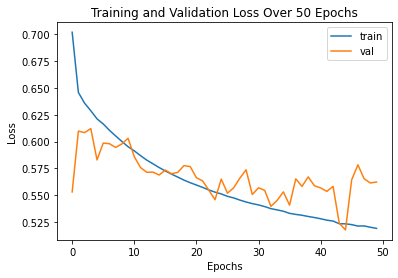

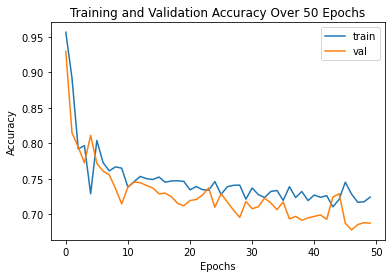

Training cross entropy: 2
[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [28]:
history.history['loss']
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.xlabel("Epochs")
pyplot.ylabel("Loss")
pyplot.title("Training and Validation Loss Over %d Epochs" % (len(history.history['loss']),))
pyplot.legend()
pyplot.show()

# dont use val_loss because of weird data points

history.history['accuracy']
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy")
pyplot.title("Training and Validation Accuracy Over %d Epochs" % (len(history.history['loss']),))
pyplot.legend()
pyplot.show()
 
from sklearn.metrics import log_loss # The data is binary
from math import sqrt
from sklearn.metrics import confusion_matrix


# model = create_model()
model.built = True
model.load_weights("ckpts/best_val_loss.hdf5")

y_pred = model.predict(X_train)
y_pred = [1 if i > 0.6 else 0 for i in y_pred] # roc curve when you change threshold
cross_entropy = log_loss(Y_train, y_pred)
print("Training cross entropy: %d" % sqrt(cross_entropy))

y_pred = model.predict(X_test)
y_pred = [1 if i > 0.6 else 0 for i in y_pred] # roc curve when you change threshold
print(y_pred)
cross_entropy = log_loss(Y_test, y_pred)
print("Testing cross entropy: %d" % sqrt(cross_entropy))

print(confusion_matrix(Y_test, y_pred))

y_pred = model.predict(X_train)
y_pred = [0 if i > 0.6 else 1 for i in y_pred]
accuracy =  np.sum(Y_train == y_pred)
# print("predict: \n", y_pred)
print("Training accuracy: %d" % accuracy)

In [ ]:
oversample = list([i for i,j in zip(X_test,Y_test) if j == 1]) # 50-50 splitish
x = np.array(list(X_test) + (20 * oversample))
y = np.array(list(Y_test) + (20*len(oversample) * [1]))
y_pred  = model.predict(x)
print(y_pred)
y_pred = [1 if i > 0.5 else 0 for i in y_pred]


[[0.14880264]
 [0.44379175]
 [0.6024997 ]
 ...
 [0.64209163]
 [0.52239424]
 [0.51203173]]


In [ ]:
print(np.sum(y_pred==y)/len(y))


0.720219704771713
